In [2]:
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 31.0 MB/s eta 0:00:00


In [4]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 24.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 35.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 29.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4

In [5]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error 
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Set some global variables to be used within this notebook

In [6]:
year = "2021" 
points_to_predict = 60
# Define number of time steps to look back to for the model (this is a bit more than a week then) 
look_back = 10

# Load the pre-computed commercial-only dataframe for a specific year specified above

In [7]:
final_df_path = 'data/yearlyData/commercial_df_' + year + '.csv'
final_df = pd.read_csv(final_df_path, sep=',', usecols=['Dew Point Temperature_P39','Power_Consumption', 'Price', 'DateTime'])

In [8]:
final_df['DateTime'] = pd.to_datetime(final_df['DateTime'])
final_df.set_index('DateTime', inplace=True)

In [9]:
final_df.tail(10)

,Power_Consumption,Dew Point Temperature_P39,Price
DateTime,,,
2021-12-31 23:00:00,0.009900,5.3,46.6
2021-12-31 23:00:00,0.001233,5.3,46.6
2021-12-31 23:00:00,0.000382,5.3,46.6
2021-12-31 23:00:00,0.000339,5.3,46.6
2021-12-31 23:00:00,0.005300,5.3,46.6
2021-12-31 23:00:00,0.000558,5.3,46.6
2021-12-31 23:00:00,0.000424,5.3,46.6
2021-12-31 23:00:00,0.000432,5.3,46.6
2021-12-31 23:00:00,0.005087,5.3,46.6


# Agregate data to get all commercial consumption (sum) in Kalmar, mean price and mean temperature per day

In [10]:
# Resample 'Power_Consumption' (sum) and 'Price' (average)
final_df_resampled = final_df.resample('D').agg({'Power_Consumption': 'sum', 'Price': 'mean', 'Dew Point Temperature_P39':'mean'})

In [11]:
final_df_resampled
max_row = final_df_resampled[final_df_resampled.Power_Consumption == final_df_resampled.Power_Consumption.max()]
max_row

,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2021-12-03,174.750927,168.088333,-8.045833


# Set value to predict

In [12]:
# Resample to every hour, taking mean of values if duplicates
y = final_df_resampled
# Fill NaNs in 'Price' column of df_prophet
y['Price'] = y['Price'].fillna(0)

# Split data into train and predict

In [13]:
y_train, y_test = temporal_train_test_split(y, test_size=points_to_predict)

# Neural network (CNN classifier)  - pure, only previous power consumption, nothing else

In [14]:
# Apply MinMax normalization
scaler = MinMaxScaler(feature_range=(0, 1))
final_df_resampled_scaled = scaler.fit_transform(final_df_resampled)

# Converting to DataFrame
final_df_resampled_scaled = pd.DataFrame(final_df_resampled_scaled, columns=final_df_resampled.columns, index=final_df_resampled.index)

In [15]:
def create_dataset(X, look_back=1):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        v = X.iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(X.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

# Split the data
train, test = final_df_resampled_scaled.Power_Consumption[:-points_to_predict], final_df_resampled_scaled.Power_Consumption[-points_to_predict:]
# Split the data (not scaled!!!)
test_original = final_df_resampled.Power_Consumption[-points_to_predict:]
train_original = final_df_resampled.Power_Consumption[:-points_to_predict]

# Reshape the data
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [16]:
# Expanding dimension from (samples, time steps) to (samples, time steps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(295, 10, 1)

In [17]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Make predictions
predictions = model.predict(X_test)
# Compute MAE
mae = mean_absolute_error(y_test, predictions)


# Calculate MSE
mse= mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MAPE

mape = mean_absolute_percentage_error(y_test, predictions)


print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE: 0.01122318917975792
RMSE: 0.10593955436831855
MAE: 0.08366929920402455
MAPE: 0.1298069912819424


In [19]:
y_test

array([0.72119037, 0.43126758, 0.34320043, 0.68883944, 0.72245866,
       0.74592486, 0.73113306, 0.65850138, 0.39713993, 0.38834548,
       0.80128471, 0.79301309, 0.76922937, 0.77755934, 0.82497282,
       0.51200574, 0.48615756, 0.86081851, 0.94224395, 0.9720025 ,
       0.95928379, 1.        , 0.62568022, 0.5221761 , 0.94923643,
       0.97172715, 0.93393799, 0.90850485, 0.94776947, 0.59944367,
       0.51635488, 0.83768326, 0.81095266, 0.79936565, 0.76785494,
       0.79769524, 0.4900737 , 0.42126226, 0.84087269, 0.91127421,
       0.87280742, 0.74869982, 0.4831029 , 0.45548961, 0.51690482,
       0.833122  , 0.84854099, 0.80812697, 0.72509033, 0.4011176 ])

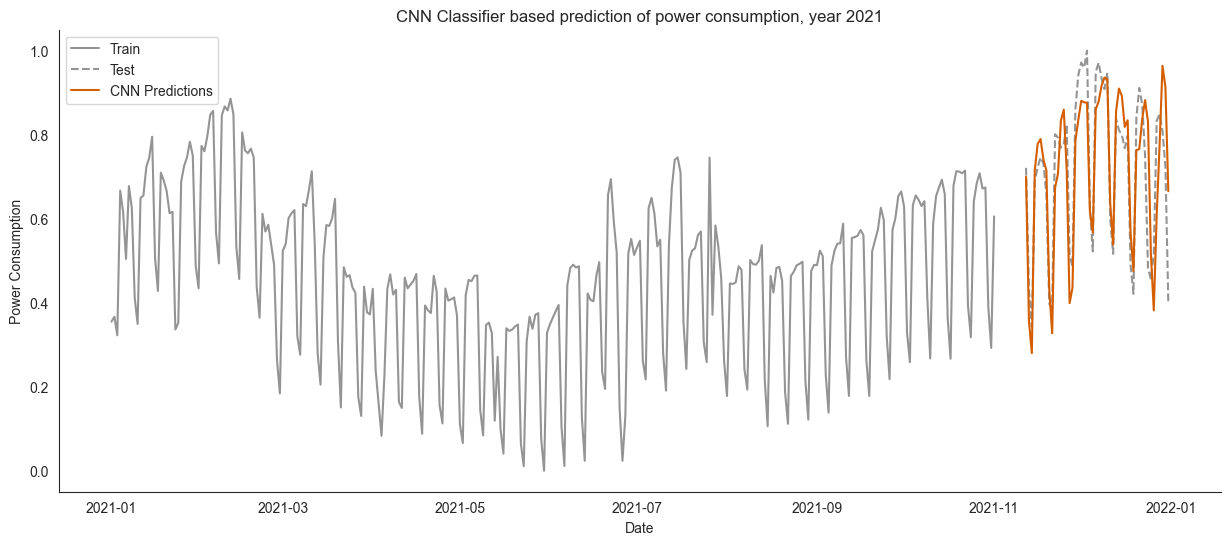

In [20]:
# Initialize Seaborn plot design
sns.set_style("white")

# Create new figure and axis
fig, ax = plt.subplots(figsize=(15,6))

# Convert y_test to pandas series
y_test_pd = pd.Series(y_test.flatten(), index=test.index[look_back:])
predictions = pd.Series(predictions.flatten(), index=test.index[look_back:])

# "Husl" palette
palette = sns.color_palette('colorblind')

# Plot the training data 
sns.lineplot(x=train.index, y=train, label='Train', ax=ax, color=palette[7])

# Plot the testing data 
sns.lineplot(x=y_test_pd.index, y=y_test_pd, label='Test', ax=ax, color=palette[7], linestyle="--")

# Plot the predictions
sns.lineplot(x=predictions.index, y=predictions, label='CNN Predictions', ax=ax, color=palette[3])

# Turn off the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Setting plot title and labels
ax.set_title('CNN Classifier based prediction of power consumption, year ' + year)
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption')

# Setting legend
ax.legend(loc='upper left')


#plt.savefig('figures/CNN_prediction_'+year+'.pdf')
plt.show()


# CNN with modified features - added Price

In [21]:
# Modifieing the create dataset function to have more columns
def create_dataset(df, col1, col2, look_back=1):
    Xs, ys = [], []
    for i in range(len(df) - look_back):
        v = df[[col1, col2]].iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(df[col1].iloc[i + look_back])
    return np.array(Xs), np.array(ys)

In [22]:
# Modify the data split section to include the entire dataframe final_df_resampled_scaled rather than just the Power_Consumption column:
# Split the data
train, test = final_df_resampled_scaled[:-points_to_predict], final_df_resampled_scaled[-points_to_predict:]

# Reshape the data
X_train, y_train = create_dataset(train, 'Power_Consumption', 'Price', look_back)
X_test, y_test = create_dataset(test, 'Power_Consumption', 'Price', look_back)

In [23]:
# Expanding dimension from (samples, time steps) to (samples, time steps, features) is not needed any more!!!!
#X_train = np.expand_dims(X_train, axis=2)
#X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(295, 10, 2)

In [24]:
model = Sequential()
# Here changing the shape of X_train
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)# Make predictions
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [26]:
# Compute MAE
mae = mean_absolute_error(y_test, predictions)


# Calculate MSE
mse= mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, predictions)


print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MSE: 0.022082210535456906
RMSE: 0.14860084298366852
MAE: 0.11271617044911146
MAPE: 34.646668690514005


In [27]:
train

,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2021-01-01,0.354947,0.069026,0.533574
2021-01-02,0.366685,0.086057,0.450385
2021-01-03,0.322409,0.046851,0.429868
2021-01-04,0.666978,0.088172,0.401144
2021-01-05,0.616911,0.096458,0.398906
...,...,...,...
2021-10-28,0.671990,0.112887,0.714748
2021-10-29,0.674342,0.131860,0.641383
2021-10-30,0.390331,0.122888,0.579085


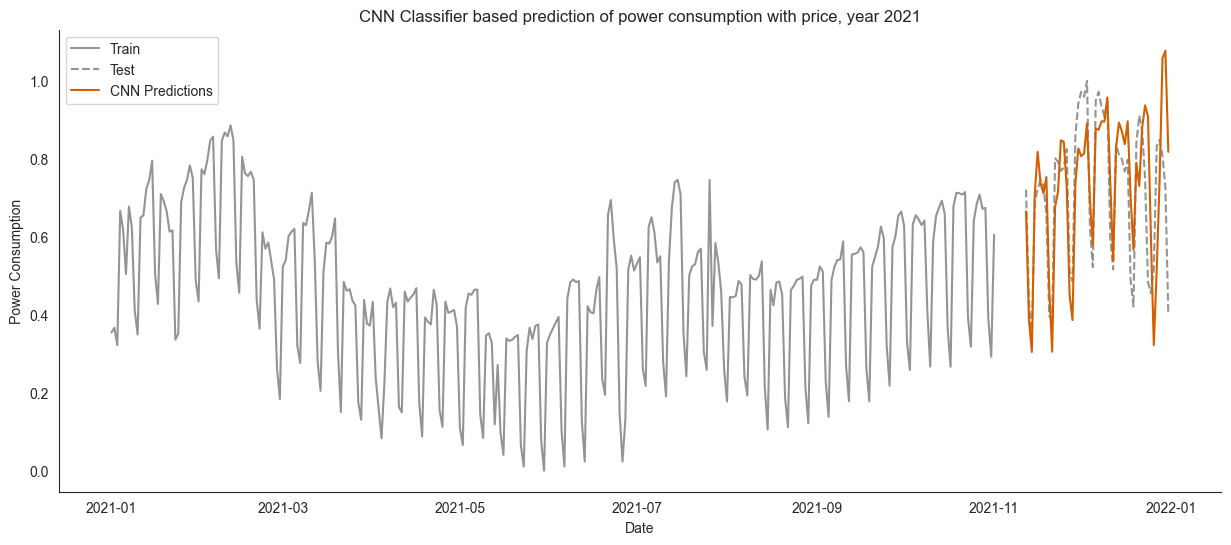

In [28]:
# Initialize Seaborn plot design
sns.set_style("white")

# Create new figure and axis
fig, ax = plt.subplots(figsize=(15,6))

# Convert y_test to pandas series
y_test_pd = pd.Series(y_test.flatten(), index=test.index[look_back:])
predictions = pd.Series(predictions.flatten(), index=test.index[look_back:])

# "Husl" palette
palette = sns.color_palette('colorblind')

# Plot the training data 
sns.lineplot(x=train.index, y=train.Power_Consumption, label='Train', ax=ax, color=palette[7])

# Plot the testing data 
sns.lineplot(x=y_test_pd.index, y=y_test_pd, label='Test', ax=ax, color=palette[7], linestyle="--")

# Plot the predictions
sns.lineplot(x=predictions.index, y=predictions, label='CNN Predictions', ax=ax, color=palette[3])

# Turn off the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Setting plot title and labels
ax.set_title('CNN Classifier based prediction of power consumption with price, year ' + year)
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption')

# Setting legend
ax.legend(loc='upper left')


#plt.savefig('figures/CNN_prediction_'+year+'_with_price.pdf')
plt.show()


# CNN with modified features - added Price & Temperature

## Let's try to generalise these functions so we can reuse them in the future

In [29]:
# Now accepts arbitrary amount of feature columns
def create_dataset(df, target, feature_cols, look_back=1):
    Xs, ys = [], []
    for i in range(len(df) - look_back):
        v = df[feature_cols].iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(df[target].iloc[i + look_back])
    return np.array(Xs), np.array(ys)

In [30]:
# Define the target and the features
target = 'Power_Consumption'
features = ['Power_Consumption', "Price", "Dew Point Temperature_P39"]  # add more features to this list as needed

# Split the data
train, test = final_df_resampled_scaled[:-points_to_predict], final_df_resampled_scaled[-points_to_predict:]

# Reshape the data
X_train, y_train = create_dataset(train, target, features, look_back)
X_test, y_test = create_dataset(test, target, features, look_back)

model = Sequential()
# Here changing the shape of X_train
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(points_to_predict, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)# Make predictions
predictions = model.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x36507aac0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


# Here are the correct metrics. TODO: Move to a function! OBS: MAPE is incorrect for the tests above

In [31]:



# Calculate MAPE
# Inverse MinMaxScaler (important!!!) 
# Reshape to match the shape of initial scale
predictions = np.array(predictions).reshape(-1, 1)

target_column_name = 'Power_Consumption' 

# Create a copy of the scaled test dataframe
test_scaled_copy = final_df_resampled_scaled[-points_to_predict:].copy()

# Replace the target column by your predictions for last points_to_predict-look_back points
test_scaled_copy.loc[test_scaled_copy.index[-(points_to_predict - look_back):], target_column_name] = predictions.ravel()

# Apply inverse transformation
predictions_inverse_scaled = scaler.inverse_transform(test_scaled_copy)

# Convert predictions_inverse_scaled to a dataframe to make indexing simpler
predictions_inverse_scaled = pd.DataFrame(predictions_inverse_scaled, columns=test_scaled_copy.columns, index=test_scaled_copy.index)

# Extract the target values that are inverse scaled
predictions_inverse_scaled = predictions_inverse_scaled.loc[test_scaled_copy.index[-(points_to_predict-look_back):], target_column_name]


# Compute MAE
mae = mean_absolute_error(test_original[-len(predictions_inverse_scaled):], predictions_inverse_scaled)


# Calculate MSE
mse= mean_squared_error(test_original[-len(predictions_inverse_scaled):], predictions_inverse_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_original[-len(predictions_inverse_scaled):], predictions_inverse_scaled))

# Calculate MAE
mae = mean_absolute_error(test_original[-len(predictions_inverse_scaled):], predictions_inverse_scaled)

# Calculate MAPE between original values and inverse scaled predictions
mape = mean_absolute_percentage_error(test_original[-len(predictions_inverse_scaled):], predictions_inverse_scaled)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MSE: 67.01066521205006
RMSE: 8.186004227463485
MAE: 6.697845913054772
MAPE: 4.387147728997431


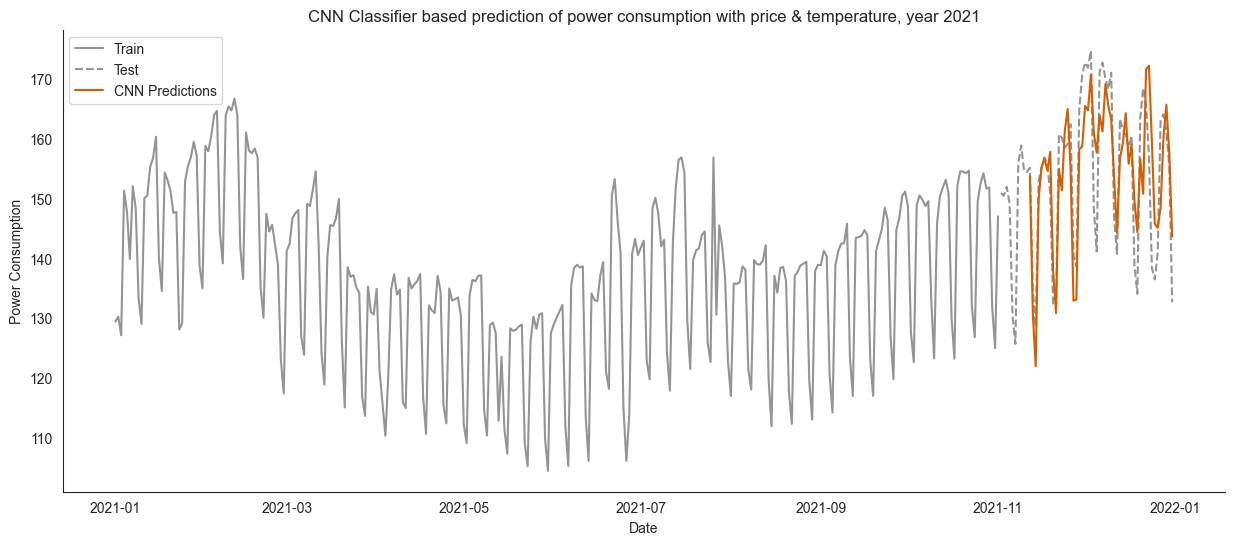

In [32]:
# Initialize Seaborn plot design
sns.set_style("white")

# Create new figure and axis
fig, ax = plt.subplots(figsize=(15,6))

# "Husl" palette
palette = sns.color_palette('colorblind')

# Plot the training data 
sns.lineplot(x=train_original.index, y=train_original, label='Train', ax=ax, color=palette[7])

# Plot the testing data 
sns.lineplot(x=test_original.index, y=test_original, label='Test', ax=ax, color=palette[7], linestyle="--")

# Plot the predictions
sns.lineplot(x=predictions_inverse_scaled.index, y=predictions_inverse_scaled, label='CNN Predictions', ax=ax, color=palette[3])


# Turn off the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Setting plot title and labels
ax.set_title('CNN Classifier based prediction of power consumption with price & temperature, year ' + year)
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption')

# Setting legend
ax.legend(loc='upper left')


#plt.savefig('figures/CNN_prediction_'+year+'_with_temperature_and_price.pdf')
plt.show()


# CNN with modified features - added Temperature

In [33]:
# Modifieing the create dataset function to have more columns
def create_dataset(df, col1, col2, look_back=1):
    Xs, ys = [], []
    for i in range(len(df) - look_back):
        v = df[[col1, col2]].iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(df[col1].iloc[i + look_back])
    return np.array(Xs), np.array(ys)

In [34]:
# Modify the data split section to include the entire dataframe final_df_resampled_scaled rather than just the Power_Consumption column:
# Split the data
train, test = final_df_resampled_scaled[:-points_to_predict], final_df_resampled_scaled[-points_to_predict:]

# Reshape the data
X_train, y_train = create_dataset(train, 'Power_Consumption', 'Dew Point Temperature_P39', look_back)
X_test, y_test = create_dataset(test, 'Power_Consumption', 'Dew Point Temperature_P39', look_back)

In [35]:
# Expanding dimension from (samples, time steps) to (samples, time steps, features) is not needed any more!!!!
#X_train = np.expand_dims(X_train, axis=2)
#X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(295, 10, 2)

In [36]:
model = Sequential()
# Here changing the shape of X_train
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)# Make predictions
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [38]:
# Compute MAE
mae = mean_absolute_error(y_test, predictions)


# Calculate MSE
mse= mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, predictions)


print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MSE: 0.012267603928689532
RMSE: 0.11075921599889343
MAE: 0.08060823240996182
MAPE: 35.953645180468015


In [40]:
train

,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2021-01-01,0.354947,0.069026,0.533574
2021-01-02,0.366685,0.086057,0.450385
2021-01-03,0.322409,0.046851,0.429868
2021-01-04,0.666978,0.088172,0.401144
2021-01-05,0.616911,0.096458,0.398906
...,...,...,...
2021-10-28,0.671990,0.112887,0.714748
2021-10-29,0.674342,0.131860,0.641383
2021-10-30,0.390331,0.122888,0.579085


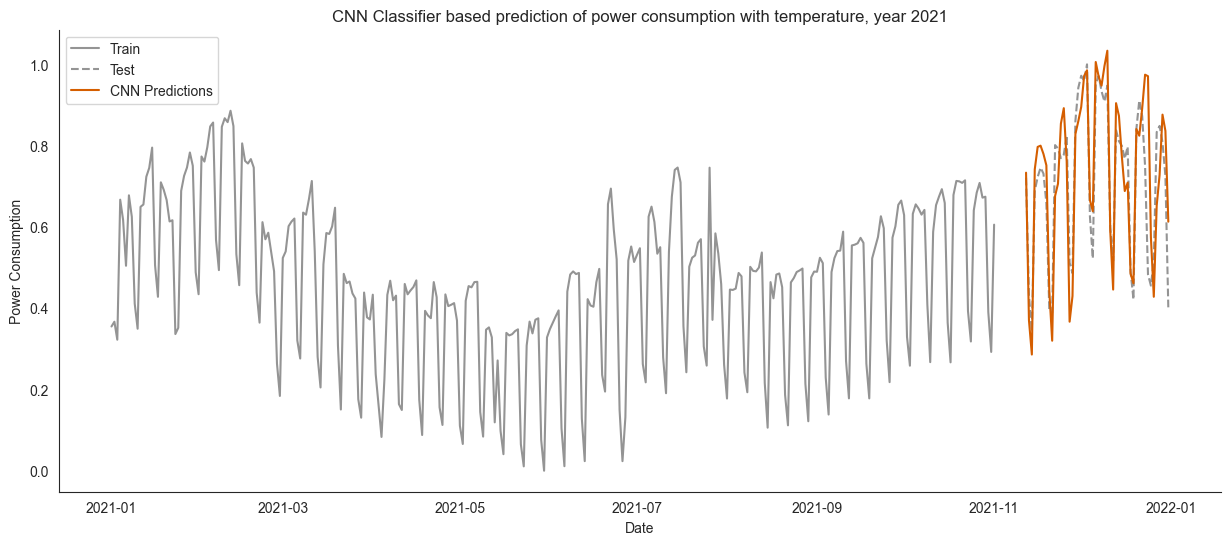

In [41]:
# Initialize Seaborn plot design
sns.set_style("white")

# Create new figure and axis
fig, ax = plt.subplots(figsize=(15,6))

# Convert y_test to pandas series
y_test_pd = pd.Series(y_test.flatten(), index=test.index[look_back:])
predictions = pd.Series(predictions.flatten(), index=test.index[look_back:])

# "Husl" palette
palette = sns.color_palette('colorblind')

# Plot the training data 
sns.lineplot(x=train.index, y=train.Power_Consumption, label='Train', ax=ax, color=palette[7])

# Plot the testing data 
sns.lineplot(x=y_test_pd.index, y=y_test_pd, label='Test', ax=ax, color=palette[7], linestyle="--")

# Plot the predictions
sns.lineplot(x=predictions.index, y=predictions, label='CNN Predictions', ax=ax, color=palette[3])

# Turn off the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Setting plot title and labels
ax.set_title('CNN Classifier based prediction of power consumption with temperature, year ' + year)
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption')

# Setting legend
ax.legend(loc='upper left')


#plt.savefig('figures/CNN_prediction_'+year+'_with_temperature.pdf')
plt.show()